In [25]:
# importing necessary modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
#reading the data from the unemployment rate excel file as a dataframe
file = "https://raw.githubusercontent.com/raghav0900/CSAM-Rsearch-Project/main/UNRATE.csv"
ts = pd.read_csv(file)
#setting index as observation date column
ts = ts.set_index(["observation_date"])
#previewing first five columns of the dataframe
ts.head(5)


,UNRATE
observation_date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


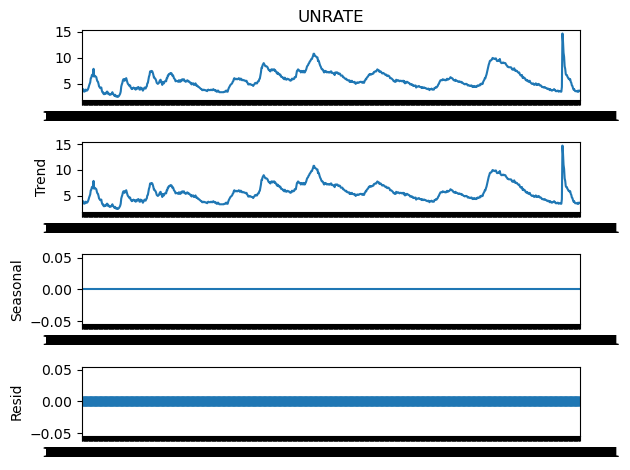

In [26]:
#decomposition of the graph or data to break it down into the three ARIMA components
decomposition = sm.tsa.seasonal_decompose(ts['UNRATE'], model = 'additive', period = 1)
#plots the three ARIMA components
fig = decomposition.plot()

#plot shows there is no seasonal component, no clear trend, and little residual component
#x axis is the date
#only for visualization

In [27]:
#performing ad-fuller test and evaluating p value to check the stationarity of the time series data
#using a condition statement (if statement)
from statsmodels.tsa.stattools import adfuller
adftest = adfuller(ts)
print("P value: ", adftest[1])
if adftest[1] < 0.05:
    print("Time series is stationary") #no differencing is needed if time series is stationary
else:
    print("Time series is not stationary") # differencing is needed if time series is not stationary

P value:  0.002096949539703996
Time series is stationary


In [28]:
len(ts) #number of rows in the dataframe
from sklearn.metrics import mean_squared_error

#splitting dataset into training and testing dataset
train = ts['UNRATE'][0 : 449] #449 values, index 0 to 448 inclusive
test = ts['UNRATE'][449: len(ts)] #450 values, index 449 to 898 inclusive

import itertools
#creating range of values for the p,q, and d parameters in the sm.tsa.arima.ARIMA() function
p = range(0,10)
q = range(0,10)
d = range(0,2)

order1 = [] #stores all the pdq combinations
rmse = [] #stores root mean squared error for RMSE performed between 1) prediction on test data and 2) test data
pdq_combination = list(itertools.product(p,d,q))
#for loop to determine the optimal pdq combination that will give the smallest root mean squared error (RMSE)
for pdq in pdq_combination:
    model = sm.tsa.arima.ARIMA(train, order=pdq).fit()
    pred = model.predict(start = len(train), end = len(ts) - 1)
    error = np.sqrt(mean_squared_error(test,pred)) #function to calculate rmse
    order1.append(pdq) #adding the pdq combination to the order array
    rmse.append(error) #adding rmse value calculated as "error" to the rmse array
    
minimum_rmse = min(rmse) #find minimum rmse
index = rmse.index(minimum_rmse) #find position of minimum rmse in the rmse array
pdq_optimum = pdq_combination[index] #use index obtained in previous step to get the optimal pdq combination determined by the for loop
print("Optimal (p,d,q) Values: " + str(pdq_optimum))
print("Minimum RMSE: " + str(minimum_rmse))

Optimal (p,d,q) Values: (3, 0, 5)
Minimum RMSE: 1.6298594695407067


In [29]:
#re-running ARIMA model on train dataset to predict values in test dataset to double check
#using pdq optimum values found in for loop
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train, order= pdq_optimum)
model = model.fit()
pred = model.predict(start = len(train), end = len(ts) - 1)

In [30]:
#previewing predicted values of the test data set (index 450 to 898 in original dataset)
pred.head(5)

1985-06-01    7.166636
1985-07-01    7.150577
1985-08-01    7.088287
1985-09-01    7.089041
1985-10-01    7.008818
Freq: MS, Name: predicted_mean, dtype: float64

In [31]:
#re-calculating RMSE for confirmation
error = np.sqrt(mean_squared_error(test,pred))
error

1.6298594695407067

In [32]:
#non-seasonal ARIMA model is applied on the entire unemployment rate data 
#to forecast unemployment rates for future dates past 2022-11-01
final_model = sm.tsa.arima.ARIMA(ts, order=pdq_optimum)
final_model = final_model.fit()
final_prediction_unemployment = final_model.predict(start = len(ts), end = len(ts) + 100)

In [33]:
#previewing last 5 rows of the unemployment rate dataset
ts.tail(5)

,UNRATE
observation_date,
2022-07-01,3.5
2022-08-01,3.7
2022-09-01,3.5
2022-10-01,3.7
2022-11-01,3.7


In [34]:
#forecasted unemployment rate (%) for the next 100 months
final_prediction_unemployment

2022-12-01    3.732274
2023-01-01    3.822976
2023-02-01    3.860125
2023-03-01    3.938896
2023-04-01    3.990202
                ...   
2030-12-01    5.497986
2031-01-01    5.499133
2031-02-01    5.500230
2031-03-01    5.501279
2031-04-01    5.502283
Freq: MS, Name: predicted_mean, Length: 101, dtype: float64

In [35]:
#forecasted employment rate (%) for the next 100 months
final_prediction_employment = 100 - final_prediction_unemployment

In [36]:
final_prediction_employment


2022-12-01    96.267726
2023-01-01    96.177024
2023-02-01    96.139875
2023-03-01    96.061104
2023-04-01    96.009798
                ...    
2030-12-01    94.502014
2031-01-01    94.500867
2031-02-01    94.499770
2031-03-01    94.498721
2031-04-01    94.497717
Freq: MS, Name: predicted_mean, Length: 101, dtype: float64